In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from scipy import stats
pl.enable_string_cache()
plt.rcdefaults()
plt.style.use('default')



### functions to draw cue box and assign sex

In [3]:

from coral.config_loader import ConfigLoader
from coral.experimental_metadata import ExperimentMetaData
from coral.data_preprocessor import BehaviorDataPreprocessor, PhotometryDataPreprocessor
config_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/conf/config.yaml'
configs = ConfigLoader(config_path)
path_to_save_figures = Path("/Users/mds8301/Desktop/lha_paper/figures/pavlovian")

In [4]:
# Your date is in MM-DD-YYYY format, so use:
sucralose_date = datetime.datetime.strptime(configs.config_data['reward_dates']['sucralose'], '%m-%d-%Y').date()



In [16]:
def draw_cue_box(ax, color, alpha):
    #  draw box on plot for cue
    y_lower = ax.get_ylim()[0]
    y_ags_sum = sum(np.abs(ax.get_ylim()))
    rect = patches.Rectangle(
        (0, y_lower), width=5, height=y_ags_sum, alpha=alpha, facecolor=color)
    ax.add_patch(rect)
    return rect


### paths to data

In [5]:
behavior_path = Path(
    '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_behavior_data.parquet')
fp_path = Path('/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_photometry_data.parquet')
# filter_date = datetime.date(2024, 2, 1)

In [6]:
bh_df = pl.read_parquet(behavior_path).drop("__index_level_0__").sort('date').sort('subject')


baselines = (bh_df
             .filter(
                 (pl.col('time') <0) 
                 & 
                 (pl.col('time') > -3))
             .group_by(['subject', 'date']).mean()
             .drop(['time', 'time_recorded', 'user'])
             .sort('date', descending=True)
             )
baseline_corrected_df = (bh_df
                         .filter(pl.col('date') < sucralose_date)
             .join(baselines, on = ['subject', 'date'], how = 'left', suffix = '_baseline')
             .with_columns(
                 (pl.col('encoder_aligned_to_cue') - pl.col('encoder_aligned_to_cue_baseline')).alias('encoder_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_cue') - pl.col('lick_aligned_to_cue_baseline')).alias('lick_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_reward') - pl.col('lick_aligned_to_reward_baseline')).alias('lick_aligned_to_reward_baseline_corrected'),
                 (pl.col('encoder_aligned_to_reward') - pl.col('encoder_aligned_to_reward_baseline')).alias('encoder_aligned_to_reward_baseline_corrected'),
                 (pl.col('subject').cast(pl.Int32)),
                 (pl.col('date').cast(pl.Date))
             )
             .drop(['sucralose_baseline', 'male_baseline','lick_aligned_to_cue', 'encoder_aligned_to_cue', 'lick_aligned_to_reward', 'encoder_aligned_to_reward', 'lick_aligned_to_reward_baseline', 'encoder_aligned_to_reward_baseline', 'encoder_aligned_to_cue_baseline', 'lick_aligned_to_cue_baseline'])
)
# every_other_day = baseline_corrected_df['date'].unique()[::2]




In [11]:
baseline_corrected_df

subject,user,date,time_recorded,time,male,sucralose,encoder_aligned_to_cue_baseline_corrected,lick_aligned_to_cue_baseline_corrected,lick_aligned_to_reward_baseline_corrected,encoder_aligned_to_reward_baseline_corrected
i32,cat,date,datetime[ns],f64,bool,bool,f64,f64,f64,f64
117,"""User""",2024-02-01,2024-03-07 14:53:30,-10.0,false,false,-2.510081,-0.110887,0.252016,0.735887
117,"""User""",2024-02-01,2024-03-07 14:53:30,-9.805195,false,false,-2.1875,-0.272177,0.252016,0.252016
117,"""User""",2024-02-01,2024-03-07 14:53:30,-9.61039,false,false,-2.1875,-0.272177,0.252016,0.574597
117,"""User""",2024-02-01,2024-03-07 14:53:30,-9.415584,false,false,-2.1875,-0.110887,0.252016,0.252016
117,"""User""",2024-02-01,2024-03-07 14:53:30,-9.220779,false,false,-2.1875,0.050403,0.252016,-0.877016
…,…,…,…,…,…,…,…,…,…,…
38131,"""User""",2024-02-21,2024-03-07 13:04:51,19.220779,true,false,0.862069,0.49569,0.107759,-16.616379
38131,"""User""",2024-02-21,2024-03-07 13:04:51,19.415584,true,false,-0.689655,0.668103,0.107759,-19.030172
38131,"""User""",2024-02-21,2024-03-07 13:04:51,19.61039,true,false,-0.862069,0.49569,-0.064655,-17.133621


# Licks aligned to cue

In [18]:
unique_dates = sorted(baseline_corrected_df['date'].unique())
every_other_day = unique_dates[::3]  # Take every 3rd day


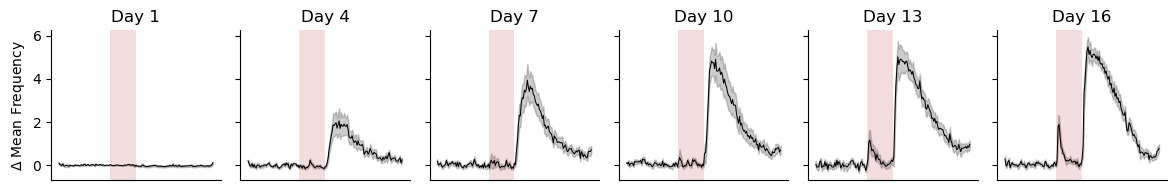

In [19]:
day_number_only = [1]
for i in range(1, len(every_other_day)):
    day_number_only.append(day_number_only[-1]+3)
day_number = [f'Day {i}' for i in day_number_only]

plot_df = (baseline_corrected_df
           .filter(
              #  (pl.col('date')>filter_date)
              #      &
        (pl.col('date').is_in(every_other_day))
           )
           .to_pandas(date_as_object=True)
)
 

# Your existing code for day_number and plot_df setup...

# Create the FacetGrid
facet = sns.FacetGrid(plot_df,
                      col='date',
                      col_wrap=6,
                      height=2,
                      aspect = 1, 
                      sharey=True,
                      margin_titles=False)

# Map the plot
facet.map(sns.lineplot, 'time',
          'lick_aligned_to_cue_baseline_corrected', 
          color='black', 
          errorbar='se', 
          err_style='band',
          linewidth=0.75)

# Set titles and boxes
for ax, day in zip(facet.axes.flat, day_number):
    ax.set_title(day)
    draw_cue_box(ax, color='#c75858', alpha=0.2)
    ax.set_xticks([])
    ax.set_xlabel('')

# Set y label only for leftmost plots
for ax in facet.axes.flat:
    # Remove all y labels first
    ax.set_ylabel('')

# Add y labels only to leftmost plots
n_cols = 6  # Your col_wrap value
for idx, ax in enumerate(facet.axes.flat):
    if idx % n_cols == 0:  # This will be true for leftmost plots
        ax.set_ylabel(r'$\Delta$ Mean Frequency')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'

plt.savefig(path_to_save_figures / 'licks_aligned_to_cue.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [24]:
for i in baseline_corrected_df.select(pl.col(['subject'])).unique():
    print(i)

shape: (10,)
Series: 'subject' [i32]
[
	117
	3634
	3812
	3814
	3816
	3818
	3819
	3820
	5079
	38131
]


In [10]:
numb_subjects = baseline_corrected_df.select(pl.col(['subject']).n_unique())



In [11]:
males = baseline_corrected_df.filter(pl.col('male') == True).select(pl.col(['subject']).n_unique())
females = baseline_corrected_df.filter(pl.col('male') == False).select(pl.col(['subject']).n_unique())


# number of subjects in behavior = 10
# 5 males & 5 females 

### mean anticipatory licks

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1648144732.py:31: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.pointplot(data = df,
/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1648144732.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


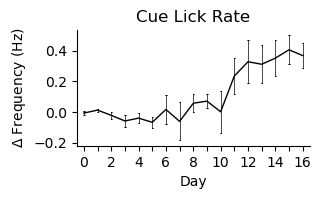

In [12]:
def compute_lick_aggregates(df, start_time, end_time):

    agg_df =(
        df
                .filter(
                    (pl.col('time') >= start_time) 
                    & 
                    (pl.col('time') <= end_time)
                    # & 
                    # (pl.col('date').is_in(every_other_day))
                    )
                .group_by(['subject', 'date', 'sucralose'])
                .agg([
                    pl.col('lick_aligned_to_cue_baseline_corrected').mean().alias(
                        'mean_lick'),
                    pl.col('lick_aligned_to_cue_baseline_corrected').max().alias(
                        'max_lick')
                ])
                .sort('date')
                .with_columns(
                    (pl.col('subject').cast(pl.Int64))
                )
    )
    return agg_df

def plot_anticipatory_licks(df, col, title, save_path = None, save = False):
    days = len(df['date'].unique())
    day_range = range(days)
    fig, ax = plt.subplots(figsize=(3, 1.5))
    
    sns.pointplot(data = df,
                x = 'date',
                y=col,
                hue = 'sucralose',
                palette=['black', 'darkred'],
                errorbar='se', 
                linewidth=1, 
                color = 'black',
                markersize = 0,
                capsize=0.1,
                err_kws = {"color":'black', 
                            "linewidth": .5},
                
                )


    # Get current axis
    ax = plt.gca()  # gets current axis
    ax.legend_.remove()
    for idx, label in enumerate(ax.get_xticklabels()):
        if idx % 2 != 0:
            label.set_visible(False)
    
    # Set tick labels and rotation
    ax.set_xticklabels(day_range, rotation=0)
    ax.set_ylabel(r'$\Delta$ Frequency (Hz)')
    ax.set_xlabel('Day')
    ax.set_title(title)
    sns.despine()
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path / f'{title.lower().replace(" ", "_")}.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()
grouped_baseline_al = compute_lick_aggregates(baseline_corrected_df, 0, 5)
cue_licks = grouped_baseline_al.to_pandas(date_as_object=True)
plot_anticipatory_licks(df = cue_licks, col = 'mean_lick', title = 'Cue Lick Rate')

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1648144732.py:31: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.pointplot(data = df,
/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1648144732.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


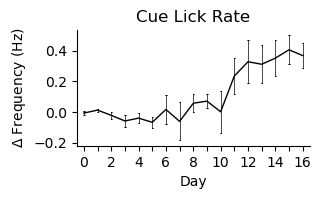

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1648144732.py:31: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.pointplot(data = df,
/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1648144732.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


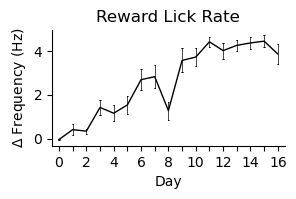

In [13]:
reward_licks = compute_lick_aggregates(baseline_corrected_df, 5, 10)
reward_licks_pd = reward_licks.to_pandas(date_as_object=True)

plot_anticipatory_licks(df = cue_licks, col = 'mean_lick', title = 'Cue Lick Rate', save_path = path_to_save_figures, save = True)
plot_anticipatory_licks(df = reward_licks_pd, col = 'mean_lick', title = 'Reward Lick Rate', save_path = path_to_save_figures, save = True)


#### read fp data and calculate group average

In [15]:
#processing is dropping males coloumns
fp_df = pl.read_parquet(fp_path).sort('date').sort('subject').filter((pl.col('date') < sucralose_date) & (pl.col('structures') == 'LHA'))
grouped_fp = (fp_df
              .drop('time', 'user')
              .group_by(*[c for c in fp_df.columns if c not in ['z_score', 'time', 'trial', 'user']])
              .mean()
              .with_columns(pl.col('date').cast(pl.Date))
            #   .to_pandas(date_as_object=True)
)
# Standardize z_score to range from 0 to 1
# grouped_fp = grouped_fp.with_columns(
#     ((pl.col('z_score') - pl.col('z_score').min()) / 
#      (pl.col('z_score').max() - pl.col('z_score').min())).alias('z_score')
# )
grouped_fp


timestamps,behavioral_events,structures,subject,date,male,sucralose,trial,z_score
f32,cat,cat,i64,date,bool,bool,f64,f32
-4.544516,"""reward""","""LHA""",5079,2024-02-01,false,false,14.0,-0.135305
-8.673363,"""reward""","""LHA""",117,2024-02-20,false,false,15.0,0.181319
8.13694,"""cue""","""LHA""",3816,2024-02-13,true,false,14.5,0.238076
9.80814,"""cue""","""LHA""",3819,2024-02-16,false,false,15.0,0.017494
6.95727,"""cue""","""LHA""",3812,2024-02-07,true,false,15.5,-0.062489
…,…,…,…,…,…,…,…,…
0.174165,"""cue""","""LHA""",117,2024-02-01,false,false,15.5,-0.018982
-6.215716,"""cue""","""LHA""",3634,2024-02-08,true,false,15.5,0.295089
-3.364846,"""cue""","""LHA""",3818,2024-02-02,false,false,15.5,0.003405


# Cue Response

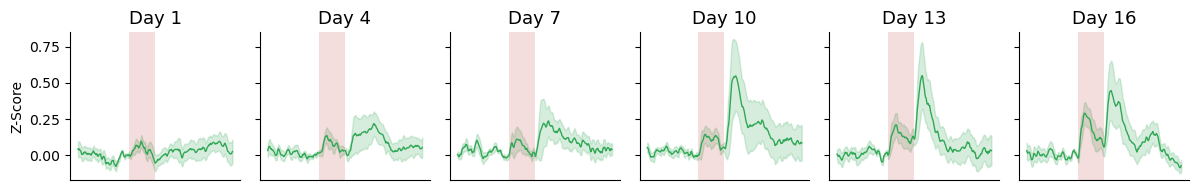

<Figure size 640x480 with 0 Axes>

In [16]:


def plot_fp_response(event, path_to_save = None, save = False):
    
    sucralose_start = datetime.datetime.strptime(
        configs.config_data['reward_dates']['sucralose'], '%m-%d-%Y').date()
    
    filtered_data = (grouped_fp
                     .filter(
                         (pl.col('behavioral_events') == event)
                         & 
                         (pl.col('date').is_in(every_other_day))
                         )
                         .sort('date')
                     )


                        
    facet = sns.FacetGrid(filtered_data.to_pandas(date_as_object=True), 
                          col='date',
                          col_wrap=6,
                        #   color = 'black',
                          height=2,
                          aspect=1,
                          margin_titles=True)
    facet.map(sns.lineplot, 'timestamps', 'z_score', color = "#32a856", errorbar='se', linewidth=1)
    for ax in facet.axes.flat:
        # ax.axvline(5, color='black', linestyle='--')
        draw_cue_box(ax, color='#c75858', alpha=0.2)
        
    for day, ax in zip(day_number, facet.axes.flat):
        label = ax.title.get_text()
        string_date = label.replace('date = ', '').replace(" 00:00:00", '')
        if len(string_date)<1:
            pass
        else:
            date = datetime.datetime.strptime(string_date,"%Y-%m-%d").date()
            if date < sucralose_start:
                ax.set_title(day)
                ax.title.set_color('black')
                # ax.title.set_weight('bold')
                # ax.xaxis.label.set_weight('bold')
                # ax.yaxis.label.set_weight('bold')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Z-Score')
                ax.title.set_fontsize(13)
                ax.set_xticks([])
                ax.set_xlabel('')
            # else:
            #     ax.title.set_color('darkred')
            #     ax.set_title(string_date)
            #     ax.set_xlabel('Time (s)')
            #     ax.set_ylabel('Z-score')
            #     ax.title.set_fontsize(13)
    
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    if save:
        plt.savefig(path_to_save / f'{event}_photometry.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()
            
    plt.tight_layout()
plot_fp_response('cue',save = True, path_to_save = path_to_save_figures)


# Reward Response

LHA cue response over days with anticipatory licks

In [159]:
# 1. Reset all parameters to default
plt.rcdefaults()

In [17]:
grouped_fp

timestamps,behavioral_events,structures,subject,date,male,sucralose,trial,z_score
f32,cat,cat,i64,date,bool,bool,f64,f32
-4.544516,"""reward""","""LHA""",5079,2024-02-01,false,false,14.0,-0.135305
-8.673363,"""reward""","""LHA""",117,2024-02-20,false,false,15.0,0.181319
8.13694,"""cue""","""LHA""",3816,2024-02-13,true,false,14.5,0.238076
9.80814,"""cue""","""LHA""",3819,2024-02-16,false,false,15.0,0.017494
6.95727,"""cue""","""LHA""",3812,2024-02-07,true,false,15.5,-0.062489
…,…,…,…,…,…,…,…,…
0.174165,"""cue""","""LHA""",117,2024-02-01,false,false,15.5,-0.018982
-6.215716,"""cue""","""LHA""",3634,2024-02-08,true,false,15.5,0.295089
-3.364846,"""cue""","""LHA""",3818,2024-02-02,false,false,15.5,0.003405


range(0, 17)


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3237216139.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


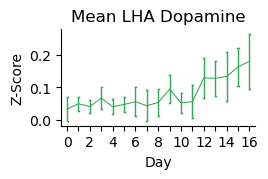

In [18]:
def compute_aggregates(df , timestart, timeend):
    return (
    df
    .rename({'z_score': 'signal'})
    .filter(
        (pl.col('timestamps') > timestart)
        &
        (pl.col('timestamps') <=timeend )
        # & 
        # (pl.col('date').is_in(every_other_day)) 
    )
    .group_by(['subject', 'date', 'structures', 'behavioral_events', 'male', 'sucralose'])
    .agg([
        pl.col('signal').max().alias('max_signal'),
        pl.col('signal').mean().alias('mean_signal'),
        pl.col('signal').sum().alias('sum_signal'),


        ])
    .sort('date')
)

def plot_consolidated_fp(y_col, df, save_path = None, save = False, event = None):
    days = len(df['date'].unique())
    day_range = range(days)
    print(day_range)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(2.5, 1.25))
    plt.rcParams['font.family'] = 'Arial'

    sns.pointplot(data=df.to_pandas().query(
        f"structures =='LHA' & behavioral_events == 'cue'"),
                x='date', 
                y=y_col,
                errorbar='se', 
                linewidth=0.75, 
                ax = ax,
                color = '#32a856',
                capsize=0.1,
                err_kws = {"color":'#32a856', 
                            "linewidth": 1},
                **{
                    'marker': 'o',
                    'markersize': 0,
                    'markerfacecolor': '#32a856',
                    'markeredgecolor': '#32a856',
                    'markeredgewidth': .5
                }
                )
    # ax.set_xticklabels(day_number_only)
    # Show every other x tick
    for idx, label in enumerate(ax.get_xticklabels()):
        if idx % 2 != 0:
            label.set_visible(False)
    ax.set_xticklabels(day_range, rotation=0)

    ax.set_ylabel('Z-Score')
    plt.xlabel('Day')

    if y_col == 'max_signal':
        plt.title(f'Max LHA Dopamine')
    if y_col == 'mean_signal':
        plt.title(f'Mean LHA Dopamine')
    sns.despine()
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path / f'{y_col}_{event}_agg_photometry.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()

fp_anticipatory = compute_aggregates(grouped_fp, 0, 5)
fp_reward = compute_aggregates(grouped_fp, 5, 10)

plot_consolidated_fp('mean_signal', fp_anticipatory, event = 'cue')

range(0, 17)


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3237216139.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


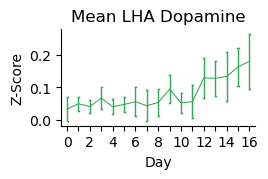

range(0, 17)


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3237216139.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


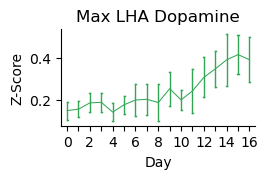

range(0, 17)


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3237216139.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


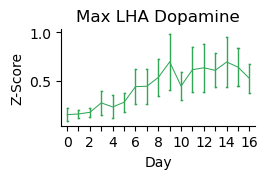

range(0, 17)


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3237216139.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


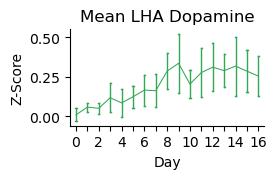

In [19]:
plot_consolidated_fp('mean_signal', fp_anticipatory, save_path=path_to_save_figures, save=True, event = 'cue')
plot_consolidated_fp('max_signal', fp_anticipatory, save_path=path_to_save_figures, save=True, event = 'cue')
plot_consolidated_fp('max_signal', fp_reward, save_path=path_to_save_figures, save=True, event = 'reward')
plot_consolidated_fp('mean_signal', fp_reward, save_path=path_to_save_figures, save=True, event = 'reward')

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3139706501.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


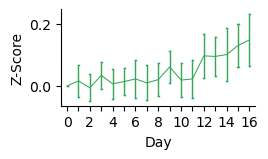

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/3139706501.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(day_range, rotation=0)


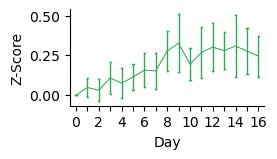

In [20]:
def compute_baseline_values(df):  
    filter_df = (df
             .select(pl.col(['subject', 'date', 'behavioral_events', 'mean_signal', 'max_signal', 'sum_signal']))
)
    # Group by subject and behavioral_events to get first date values as baseline
    baseline_values = (filter_df
        .group_by(['subject', 'behavioral_events'])
        .agg(
            pl.col('mean_signal').first().alias('mean_signal_baseline'),
            pl.col('max_signal').first().alias('max_signal_baseline'),
            pl.col('sum_signal').first().alias('sum_signal_baseline')
        )
    )

    # Join baseline values back to original dataframe
    normalized_df = (filter_df
        .join(
            baseline_values,
            on=['subject', 'behavioral_events']
        )
        .with_columns([
            (pl.col('mean_signal') - pl.col('mean_signal_baseline')).alias('mean_signal_normalized'),
            (pl.col('max_signal') - pl.col('max_signal_baseline')).alias('max_signal_normalized'), 
            (pl.col('sum_signal') - pl.col('sum_signal_baseline')).alias('sum_signal_normalized')
        ])
    )
    return normalized_df

cue_baseline = compute_baseline_values(fp_anticipatory)
reward_baseline = compute_baseline_values(fp_reward)


def plot_normalized_fp(y_col, df, save_path = None, save = False, event = None):
    days = len(df['date'].unique())
    day_range = range(days)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(2.5, 1.25))
    plt.rcParams['font.family'] = 'Arial'

    sns.pointplot(data=df.to_pandas().query(f"behavioral_events == 'cue'"),
                x='date', 
                y=y_col,
                errorbar='se', 
                linewidth=0.75, 
                ax = ax,
                color = '#32a856',
                capsize=0.1,
                err_kws = {"color":'#32a856', 
                            "linewidth": 1},
                **{
                    'marker': 'o',
                    'markersize': 0,
                    'markerfacecolor': '#32a856',
                    'markeredgecolor': '#32a856',
                    'markeredgewidth': .5
                }
                )
    ax.set_xticklabels(day_range, rotation=0)
    # Show every other x tick
    for idx, label in enumerate(ax.get_xticklabels()):
        if idx % 2 != 0:
            label.set_visible(False)
    # ax.set_xticks(ticks=day_number_only)

    ax.set_ylabel('Z-Score')
    plt.xlabel('Day')

    if y_col == 'max_signal':
        plt.title(f'Max LHA Dopamine')
    if y_col == 'mean_signal':
        plt.title(f'Mean LHA Dopamine')
    sns.despine()
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path / f'{y_col}_{event}_agg_photometry.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()
plot_normalized_fp('mean_signal_normalized', cue_baseline, save_path=path_to_save_figures, save=False, event = 'cue')
plot_normalized_fp('mean_signal_normalized', reward_baseline, save_path=path_to_save_figures, save=False, event = 'reward')


### baseline fp and lick data merge


In [21]:
# Convert only cue_licks to Polars (since cue_baseline is already Polars)
cue_licks_pl = pl.from_pandas(cue_licks)
cue_bl = cue_baseline.filter(pl.col('behavioral_events') == 'cue').drop('behavioral_events')

# Now perform the join with Polars
cue_fp_w_licks = cue_bl.join(
    cue_licks_pl,  # using original cue_baseline since it's already Polars
    on=['subject', 'date'],
    how='inner' 
)

# Calculate 2-day moving averages for signal and licks
cue_fp_w_licks = cue_fp_w_licks.with_columns([
    pl.col('mean_signal_normalized').rolling_mean(window_size=2).alias('signal_moving_avg'),
    pl.col('mean_lick').rolling_mean(window_size=2).alias('lick_moving_avg')
])
cue_fp_w_licks



subject,date,mean_signal,max_signal,sum_signal,mean_signal_baseline,max_signal_baseline,sum_signal_baseline,mean_signal_normalized,max_signal_normalized,sum_signal_normalized,sucralose,mean_lick,max_lick,signal_moving_avg,lick_moving_avg
i64,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,bool,f64,f64,f32,f64
38131,2024-02-01,0.157601,0.243628,8.037632,0.157601,0.243628,8.037632,0.0,0.0,0.0,false,0.0,0.0,null,null
3820,2024-02-01,0.078095,0.133832,3.982845,0.078095,0.133832,3.982845,0.0,0.0,0.0,false,0.002404,0.15625,0.0,0.001202
117,2024-02-01,0.177388,0.290673,9.046781,0.177388,0.290673,9.046781,0.0,0.0,0.0,false,-0.073666,0.050403,0.0,-0.035631
5079,2024-02-01,0.155292,0.369657,7.91989,0.155292,0.369657,7.91989,0.0,0.0,0.0,false,0.0,0.0,0.0,-0.036833
3819,2024-02-01,-0.083553,0.088794,-4.261219,-0.083553,0.088794,-4.261219,0.0,0.0,0.0,false,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
117,2024-02-21,0.155984,0.35525,7.955194,0.177388,0.290673,9.046781,-0.021404,0.064577,-1.091586,false,0.655907,4.955357,0.030152,0.373626
3819,2024-02-21,-0.019911,0.115265,-1.015458,-0.083553,0.088794,-4.261219,0.063642,0.026471,3.245761,false,0.35006,3.144531,0.021119,0.502983
38131,2024-02-21,0.858952,1.1207,43.806572,0.157601,0.243628,8.037632,0.701352,0.877072,35.76894,false,0.250332,1.702586,0.382497,0.300196


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1569752923.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(day_number_only, rotation=0)


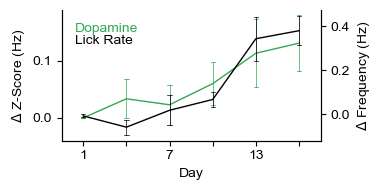

In [22]:
# Create figure and primary axis

def plot_da_with_licks(df, event = None,save_path = None, save = False):
    fig, ax1 = plt.subplots(figsize=(4,2))
    days = len(df['date'].unique())
    days_to_plot = df['date'].unique()[::3]
    day_number_only = [1]
    for i in range(1, len(days_to_plot)):
        day_number_only.append(day_number_only[-1]+3)


    filter_days = df.filter(pl.col('date').is_in(days_to_plot))
    ax2 = ax1.twinx()
    
    # ax1.set_ylim(signal_bottom, signal_top)
    # ax2.set_ylim(min_lick, max_lick)
    sns.pointplot(data=filter_days.to_pandas(date_as_object=True),
                x='date',
                y='signal_moving_avg',
                color='#32a856',  # Green color for photometry
                errorbar='se', 
                linewidth=1, 
                capsize=0.1,
                err_kws={"color":'#32a856', "linewidth": .5},
                markersize=0,
                ax=ax1)

  

    # Plot second dataset on secondary y-axis (licks)
    sns.pointplot(data=filter_days.to_pandas(date_as_object=True),
                x='date',
                y='lick_moving_avg',
                color='black',  # Black color for licks
                errorbar='se', 
                linewidth=1, 
                capsize=0.1,
                err_kws={"color":'black', "linewidth": .5},
                markersize=0,
                ax=ax2)

    # Customize axes labels and appearance
    ax1.set_xlabel('Day')
    ax1.set_ylabel(r'$\Delta$ Z-Score (Hz)', color='black')
    ax2.set_ylabel(r'$\Delta$ Frequency (Hz)', color='black')

    # Set x-axis ticks
    ax1.set_xticklabels(day_number_only, rotation=0)
    for idx, label in enumerate(ax1.get_xticklabels()):
        if idx % 2 != 0:
            label.set_visible(False)

    # Color the tick labels to match their respective plots
    # ax1.tick_params(axis='y', colors='#32a856')
    # ax2.tick_params(axis='y', colors='black')
    ax1.set_ylim(-.04)
    # Remove the right and top spines
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.text(0.05, 0.9, 'Dopamine', color = '#32a856', transform=ax1.transAxes,verticalalignment='top')
    ax1.text(0.05, 0.81, 'Lick Rate', color = 'black', transform=ax2.transAxes,verticalalignment='top')

    plt.tight_layout()
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path / f'{event}_da_with_licks.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()

plot_da_with_licks(cue_fp_w_licks, event = 'cue', save_path=path_to_save_figures, save=True)

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_36151/1569752923.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(day_number_only, rotation=0)


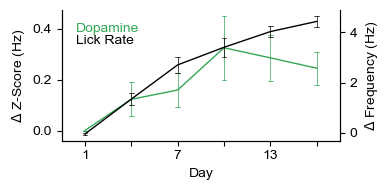

In [23]:

reward_bl = reward_baseline.filter(pl.col('behavioral_events') == 'cue').drop('behavioral_events')
reward_fp_w_licks = reward_bl.join(
    reward_licks,  # using original cue_baseline since it's already Polars
    on=['subject', 'date'],
    how='inner'
)
reward_fp_w_licks = reward_fp_w_licks.with_columns([
    pl.col('mean_signal_normalized').rolling_mean(window_size=2).alias('signal_moving_avg'),
    pl.col('mean_lick').rolling_mean(window_size=2).alias('lick_moving_avg')
])
plot_da_with_licks(reward_fp_w_licks, event = 'reward', save_path=path_to_save_figures, save=True)


subject,date,mean_signal,max_signal,sum_signal,mean_signal_baseline,max_signal_baseline,sum_signal_baseline,mean_signal_normalized,max_signal_normalized,sum_signal_normalized,sucralose,mean_lick,max_lick
i64,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,bool,f64,f64
117,2024-02-01,0.177388,0.290673,9.046781,0.177388,0.290673,9.046781,0.0,0.0,0.0,false,-0.073666,0.050403
3814,2024-02-01,0.037966,0.216933,1.936248,0.037966,0.216933,1.936248,0.0,0.0,0.0,false,0.0,0.0
38131,2024-02-01,0.157601,0.243628,8.037632,0.157601,0.243628,8.037632,0.0,0.0,0.0,false,0.0,0.0
3819,2024-02-01,-0.083553,0.088794,-4.261219,-0.083553,0.088794,-4.261219,0.0,0.0,0.0,false,0.0,0.0
3820,2024-02-01,0.078095,0.133832,3.982845,0.078095,0.133832,3.982845,0.0,0.0,0.0,false,0.002404,0.15625
…,…,…,…,…,…,…,…,…,…,…,…,…,…
3634,2024-02-20,0.247196,0.851418,12.606976,0.01632,0.134547,0.832339,0.230875,0.71687,11.774636,false,0.413805,3.325893
117,2024-02-20,0.020197,0.359252,1.030057,0.177388,0.290673,9.046781,-0.157191,0.068579,-8.016724,false,0.558687,4.762931
5079,2024-02-20,-0.001413,0.084993,-0.072083,0.155292,0.369657,7.919888,-0.156705,-0.284664,-7.991971,false,0.068554,0.56713


# Mean Signal vs Mean Anticipatory Licks

In [25]:
grouped_baseline_al

subject,date,sucralose,mean_lick,max_lick
i64,date,bool,f64,f64
38131,2024-02-01,false,0.0,0.0
3820,2024-02-01,false,0.002404,0.15625
117,2024-02-01,false,-0.073666,0.050403
5079,2024-02-01,false,0.0,0.0
3819,2024-02-01,false,0.0,0.0
…,…,…,…,…
117,2024-02-21,false,0.655907,4.955357
3819,2024-02-21,false,0.35006,3.144531
38131,2024-02-21,false,0.250332,1.702586


In [26]:
plt.close()

combined_cue_data = (fp_anticipatory
                 .join(grouped_baseline_al, on = ['subject', 'date']).sort('date')
                #  .filter(pl.col('date')>filter_date)
                )
combined_reward_data = (fp_reward
                 .join(grouped_baseline_al, on = ['subject', 'date']).sort('date')
                #  .filter(pl.col('date')>filter_date)
                )


subject,date,structures,behavioral_events,male,sucralose,max_signal,mean_signal,sum_signal,sucralose_right,mean_lick,max_lick
i64,date,cat,cat,bool,bool,f32,f32,f32,bool,f64,f64
3634,2024-02-01,"""LHA""","""cue""",true,false,0.080413,-0.018518,-0.925892,false,0.056624,0.347222
3812,2024-02-01,"""LHA""","""cue""",true,false,0.125614,-0.001843,-0.092138,false,0.0,0.0
3819,2024-02-01,"""LHA""","""cue""",false,false,0.660823,0.146031,7.301548,false,0.0,0.0
3820,2024-02-01,"""LHA""","""cue""",false,false,0.069931,0.02692,1.346024,false,0.002404,0.15625
38131,2024-02-01,"""LHA""","""cue""",true,false,0.164339,0.092778,4.638915,false,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…
3816,2024-02-21,"""LHA""","""reward""",true,false,-0.283015,-0.354087,-17.704357,false,0.65625,3.739583
3634,2024-02-21,"""LHA""","""reward""",true,false,0.197684,0.098993,4.949629,false,0.093052,1.129032
3634,2024-02-21,"""LHA""","""cue""",true,false,0.766435,0.553907,27.695324,false,0.093052,1.129032


In [245]:
fp_anticipatory

subject,date,structures,behavioral_events,male,sucralose,max_signal,mean_signal,sum_signal
i64,date,cat,cat,bool,bool,f32,f32,f32
3812,2024-02-01,"""LHA""","""reward""",true,false,0.083942,-0.044406,-2.264699
3820,2024-02-01,"""LHA""","""cue""",false,false,0.133832,0.078095,3.982845
117,2024-02-01,"""LHA""","""reward""",false,false,0.150704,0.022677,1.156551
3818,2024-02-01,"""LHA""","""reward""",false,false,0.043057,0.013145,0.67038
117,2024-02-01,"""LHA""","""cue""",false,false,0.290673,0.177388,9.046781
…,…,…,…,…,…,…,…,…
3819,2024-02-21,"""LHA""","""cue""",false,false,0.115265,-0.019911,-1.015458
38131,2024-02-21,"""LHA""","""cue""",true,false,1.1207,0.858952,43.806564
3816,2024-02-21,"""LHA""","""reward""",true,false,0.560582,0.101539,5.178485


# Peak Signal vs Max Anticipatory Licks

In [242]:
plt.close()

slope: 0.2657232830761361,
cue_intercept: 0.05025419962493667,
cue R squared value: 0.30411802951839945,
cue_p_value: 7.842170295884697e-15,
cue_std_err: 0.031104131718343277


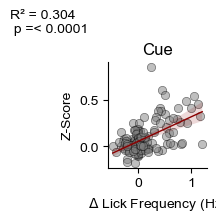

In [50]:


from typing import Literal



def plot_lmplot(df, event:Literal['cue', 'reward'], stat_type:Literal['max', 'mean'], save_path:Path = None, save = False):

    sig = df.filter(pl.col('behavioral_events') =="cue").to_pandas(date_as_object=True)
    licks = sig[f'{stat_type}_lick']
    signal = sig[f'{stat_type}_signal']
    slope, intercept, r_value, p_value, std_err = stats.linregress(licks, signal)
    print(f'slope: {slope},\ncue_intercept: {intercept},\ncue R squared value: {r_value**2},\ncue_p_value: {p_value},\ncue_std_err: {std_err}')

    sns.lmplot(data=df
           .filter(pl.col('behavioral_events') == "cue")    
           .to_pandas(date_as_object=True),
           x = f'{stat_type}_lick',
           y = f'{stat_type}_signal', 
            # hue = 'subject',
            # col_order= ['cue', 'reward'], 
            scatter_kws = {'color': 'grey', 'edgecolor': 'black', 'alpha': 0.5, 'linewidths': 0.5},
            line_kws = {'color': 'darkred', 'linewidth': 1},
            aspect = 1,
            height = 1.75,
            facet_kws = {
                'sharex':True, 
                'sharey':True    
            } 
            
            )
    plt.gcf().axes[0].set_title(event.capitalize())
    plt.gcf().axes[0].set_xlabel(r'$\Delta$ Lick Frequency (Hz)')
    plt.gcf().axes[0].set_ylabel('Z-Score')


    if p_value < 0.0001:
        p = '< 0.0001'
    else:
        p = f'{p_value:.3f}'
    plt.gcf().axes[0].text(-1,1.5, f'R² = {r_value**2:.3f}\n p ={p}', 
                        transform=plt.gcf().axes[0].transAxes,
                        verticalalignment='top')
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path / f'{event}_{stat_type}_lrplot.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close()

plot_lmplot(combined_cue_data, 'cue', 'mean', save_path=path_to_save_figures, save=True)


subject,date,structures,behavioral_events,male,sucralose,max_signal,mean_signal,sum_signal,sucralose_right,mean_lick,max_lick
i64,date,cat,cat,bool,bool,f32,f32,f32,bool,f64,f64
3816,2024-02-01,"""LHA""","""reward""",true,false,0.330238,0.177948,9.075324,false,-0.045673,0.364583
3812,2024-02-01,"""LHA""","""cue""",true,false,0.106557,0.056368,2.874769,false,0.0,0.0
38131,2024-02-01,"""LHA""","""cue""",true,false,0.243628,0.157601,8.037632,false,0.0,0.0
3816,2024-02-01,"""LHA""","""cue""",true,false,-0.042761,-0.181487,-9.255856,false,-0.045673,0.364583
3814,2024-02-01,"""LHA""","""reward""",true,false,0.015523,-0.116991,-5.966524,false,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…
117,2024-02-21,"""LHA""","""reward""",false,false,0.395724,-0.016698,-0.851613,false,0.655907,4.955357
38131,2024-02-21,"""LHA""","""reward""",true,false,0.730167,0.328076,16.731895,false,0.250332,1.702586
3634,2024-02-21,"""LHA""","""reward""",true,false,0.702386,0.47311,24.128622,false,0.093052,1.129032


slope: 0.12820610598883272,
cue_intercept: 0.10207520022950944,
cue R squared value: 0.4977631351129906,
cue_p_value: 9.220014164992047e-27,
cue_std_err: 0.009965369426515193


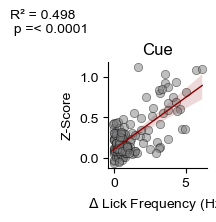

In [38]:
plot_lmplot(combined_cue_data, 'cue', 'max', save_path=path_to_save_figures, save=False)



slope: 0.5052943225982066,
cue_intercept: 0.13965396802309846,
cue R squared value: 0.19213444715539252,
cue_p_value: 2.5161269884729788e-09,
cue_std_err: 0.08017761080486316


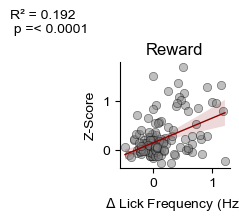

In [42]:
plot_lmplot(combined_reward_data, 'reward', 'mean', save_path=path_to_save_figures, save=True)


slope: 0.25945329992872435,
cue_intercept: 0.15711513333222876,
cue R squared value: 0.3933034498972016,
cue_p_value: 7.358878146201294e-20,
cue_std_err: 0.02493577370096621


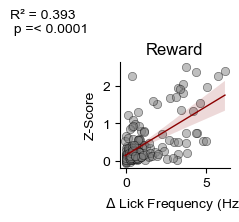

In [44]:
plot_lmplot(combined_reward_data, 'reward', 'max', save_path=path_to_save_figures, save=True)